# Model V2

This model is trained on updated dataset

In [5]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2023-04-04')
os.makedirs(tmp_path,exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

MONGO_CACHE = path.join(DATA_CACHE, 'archival', 'mongo_db') # Generated from Mongodb
AUTOGESTION_CACHE = path.join(DATA_CACHE, 'archival', 'autogestion') # generated from autogestion repository
INFERENCE_CACHE = path.join(DATA_CACHE, 'archival', 'inference') # model generation

In [7]:
from modules.logger import init_logging
from modules.logger import log

init_logging(color=True)

In [2]:
# CHECK GPU hardware

!nvidia-smi

Mon Jun  5 16:49:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:B1:00.0 Off |                  Off |
| 30%   25C    P8    13W / 230W |   5066MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading trained model

In [124]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8, version='v2')
dm.prepare_data()
dm.setup('test')

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'v2/run=7_vector=0_lentropy=0.15'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='dev',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

05-06-2023 19:05:56 |     INFO   archival_module.py:prepare_data:102  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/archival/v2/vocab.pt
05-06-2023 19:05:56 |     INFO   archival_module.py:prepare_data:104  Vocab size: 16792
05-06-2023 19:05:56 |     INFO   dataset.py:__init__:86  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/v2/test.json
05-06-2023 19:05:56 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random
Model is in cuda:  True


# Evaluation in generated test set

## Model's predictions

### Evaluate accuracy

In [10]:
import torchmetrics as m

accuracy = m.Accuracy().to(device)

all_y_true = list()
all_y_hat = list()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    accuracy.update(y_hat, y_true)
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

accuracy.compute()

tensor(0.9564, device='cuda:0')

Precision / Recall curve 

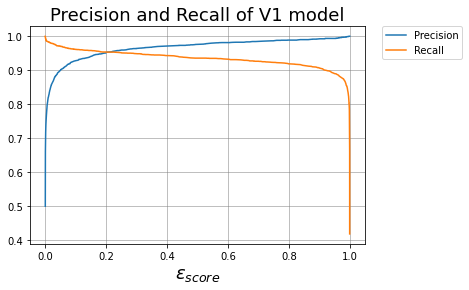

In [11]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt


precision, recall, thresholds = precision_recall_curve(all_y_true.cpu(), all_y_hat.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=0.5)
plt.title('Precision and Recall of V1 model', fontsize=18)
plt.show()

Distribution

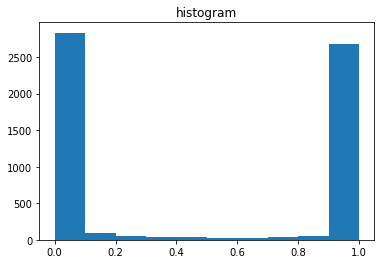

In [12]:
y_score = all_y_hat.cpu().numpy()

plt.hist(y_score) 
plt.title("histogram") 
plt.show()

## Model's attention map

In [98]:
import pandas as pd

df_inference = pd.DataFrame()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    padding_mask = batch['padding_mask']
    B = len(y_true)
    
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    a_hat = {side: a_hat[side].softmax(-1) for side in a_hat}
    a_hat = { side : [ attention[i][~padding_mask[side][i]].tolist()  for i in range(B) ] for side, attention in a_hat.items() }

    inferench_batch = {}
    for side in ['premise', 'hypothesis']:
        COLUMNS = [side + '.norm', side + '.form']
        inferench_batch.update({c : batch[c] for c in COLUMNS})
        inferench_batch.update({side + '.attention' : a_hat[side]})



    inferench_batch['y_true'] = batch['y_true'].tolist()
    inferench_batch['y_score'] = y_hat.tolist()
    
    inferench_batch = pd.DataFrame(inferench_batch)
    
    df_inference = pd.concat([df_inference, inferench_batch])
    
df_inference.reset_index(drop=True, inplace=True)

In [99]:
EPSILON_Y_HAT = 0.999

df_inference['y_hat'] = df_inference['y_score'] > EPSILON_Y_HAT

df_true_positive = df_inference[df_inference['y_hat'] & df_inference['y_true']]
df_true_positive.reset_index(drop=True, inplace=True)

print('% True positive:', len(df_true_positive) / len(df_inference))
print('# True positive:', len(df_true_positive))

% True positive: 0.3634196185286104
# True positive: 2134


In [100]:
from modules import highlight
BEGIN = 0
END = 10    

html='<table>'
html += '<thead><tr><th>Index</th> <th>Premise</th> <th>Hypothesis</th> <th>Score</th> </tr></thead>'

for idx, row in df_true_positive[BEGIN:END].iterrows():
    
    idx = str(row.name)
    #premise = [tk['form'] for tk in s_tokens]
    premise = highlight(row['premise.form'], row['premise.attention'])

    #hypothesis = ' '.join([tk['form'] for tk in t_tokens])
    hypothesis = highlight(row['hypothesis.form'], row['hypothesis.attention'])

    score = str(round(row['y_score'], 2))
    
    html += '<tr>' + '<td>' + idx + '</td>' + '<td>' +premise + '</td>' + '<td>' + hypothesis + '</td>' + '<td>' + score + '</td>' +'</tr>'
    
html += '</table>'
display(HTML(html))

Words received most of attention weight

In [16]:
import numpy as np
import json

ATTENDED_TOKEN_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions', 'words_attention_mass.json')

if path.exists(ATTENDED_TOKEN_PATH):
    
    # Load the attention mass if the file exits
    with open(ATTENDED_TOKEN_PATH, 'r') as f:
        avg_attention_mass = json.load(f)
else:

    # flatten and align tokens and attentions
    tokens = np.concatenate(df_true_positive['premise.norm'].tolist()).tolist()
    attentions = np.concatenate(df_true_positive['premise.attention'].tolist()).tolist()
    assert len(tokens) == len(attentions), 'Not compatible length'

    # cumulate attention weights
    attention_mass = {}
    word_occurence = {}
    for w, a in zip(tokens, attentions):
        # w : word
        # a : attention weight
        attention_mass[w] = attention_mass.get(w, 0) + a
        word_occurence[w] = word_occurence.get(w, 0) + 1

    # renormalized by the word frequency 
    avg_attention_mass = {w : attention_mass[w]/word_occurence[w] for w in attention_mass}
        
    # sort by descending order
    avg_attention_mass = {k: v for k, v in sorted(avg_attention_mass.items(), key=lambda item: -item[1])}

    # Save to file
    with open(ATTENDED_TOKEN_PATH, 'w') as f:
        json.dump(avg_attention_mass, f)

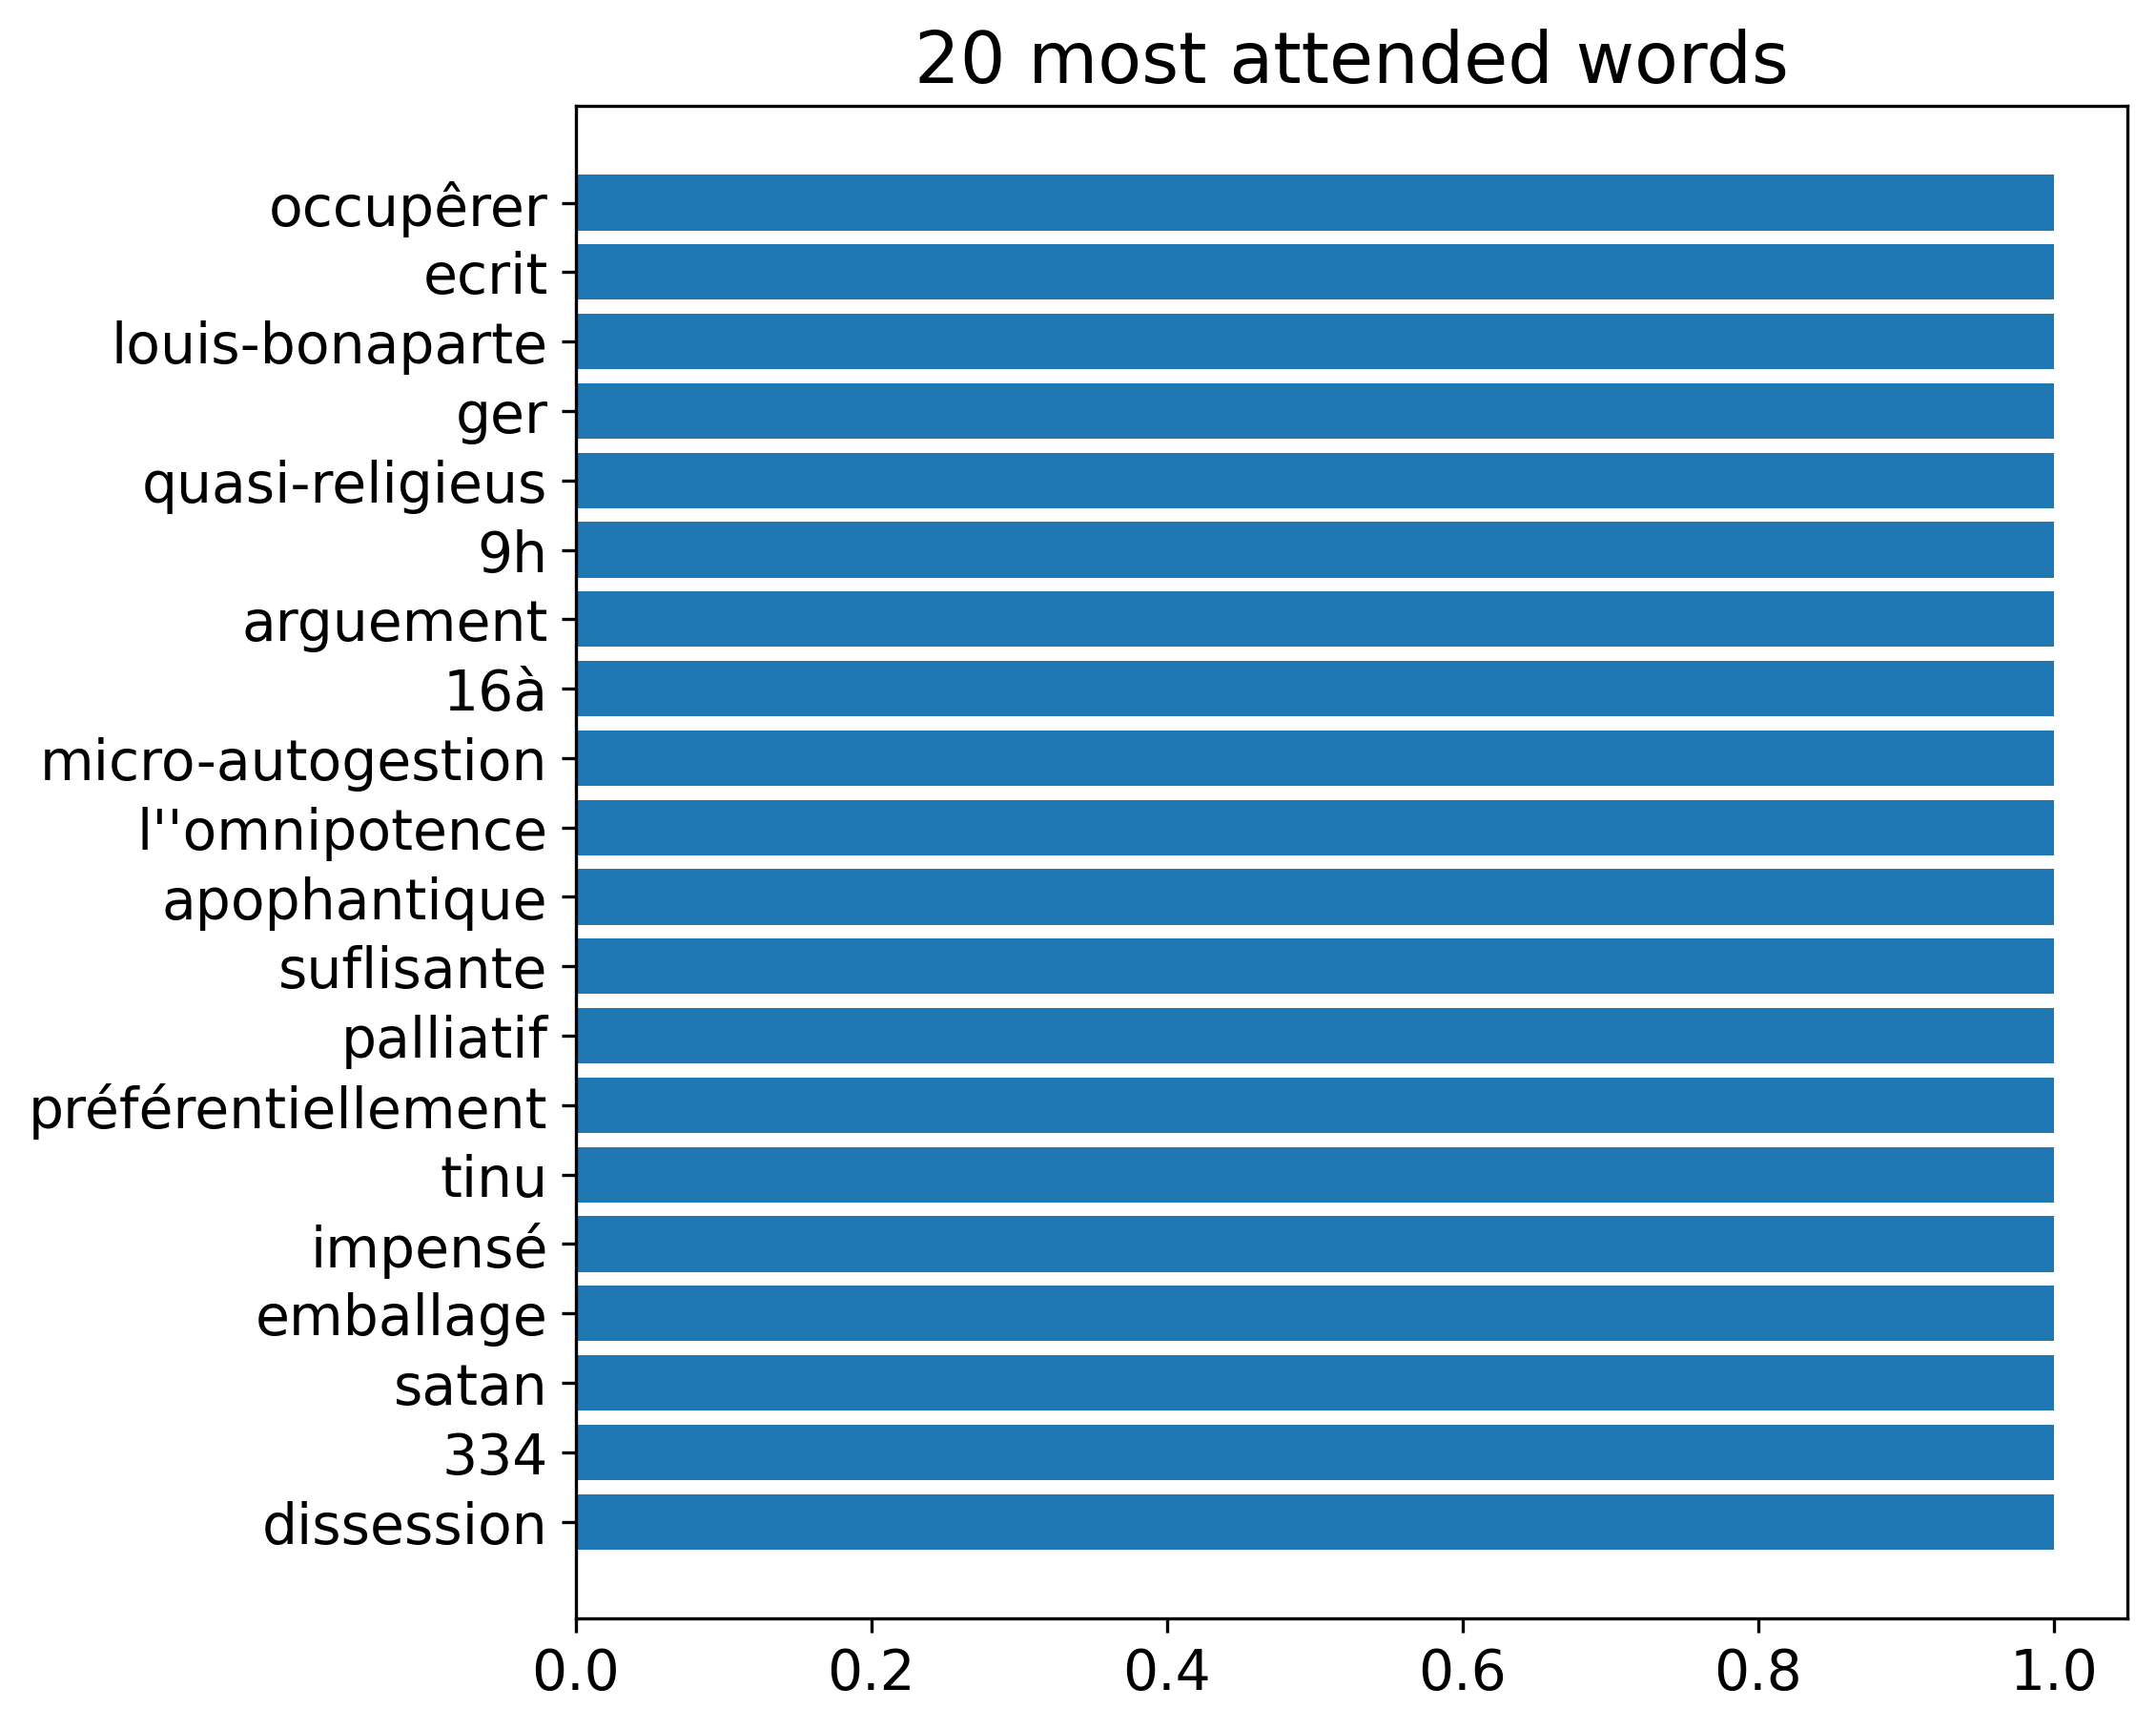

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams['figure.dpi'] = 300

N_WORDS = 20
x = list(avg_attention_mass.keys())[:N_WORDS]
y = list(avg_attention_mass.values())[:N_WORDS]
plt.barh(x[::-1], y[::-1])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'{N_WORDS} most attended words', fontsize=18)

fig_path = path.join(tmp_path, 'figures')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(path.join(fig_path, f'average_attn_mass_xnli.png'),dpi=100)
plt.show()

# Evaluation in a subset

In [18]:
%%time
import pandas as pd

std_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'std_block_links.json')
df_std_block_links = pd.read_json(std_block_links_path, dtype={'link.type':'category'})

block_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'blocks.json')
df_block = pd.read_json(block_path, encoding='utf-8')

CPU times: user 5.04 s, sys: 1.67 s, total: 6.71 s
Wall time: 10.8 s


In [19]:
article_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'articles.json')
df_article = pd.read_json(article_path)
df_article.set_index('id', inplace=True)

In [23]:
# Format df_block , create uid index for easy access
df_block['uid'] = df_block['page.id.fmsh'] + '_' + df_block['bloc.id'].astype(str).str.zfill(2)
df_block = df_block.set_index('uid')

In [24]:
from modules.archival import *
from modules import *

In [125]:
#Get a link
link = df_std_block_links.iloc[1000]

source_revue_id = link['source.revue.id.persee']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.bloc.id']

# get uid
block_uid = { side: link[f'{side}.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model)

In [126]:
# Prepare the tokens
block_words = {'source': [], 'target': []}
for side in block_words:
    block_form = get_block(df_block, block_uid[side], 'form')
    block_space = [[(' ' if s else '') for s in sent_s] for sent_s in get_block(df_block, block_uid[side], 'space_after')]
    block_words[side] = [[f+s for f, s in zip(block_f, block_s)] for block_f, block_s in zip(block_form, block_space)]

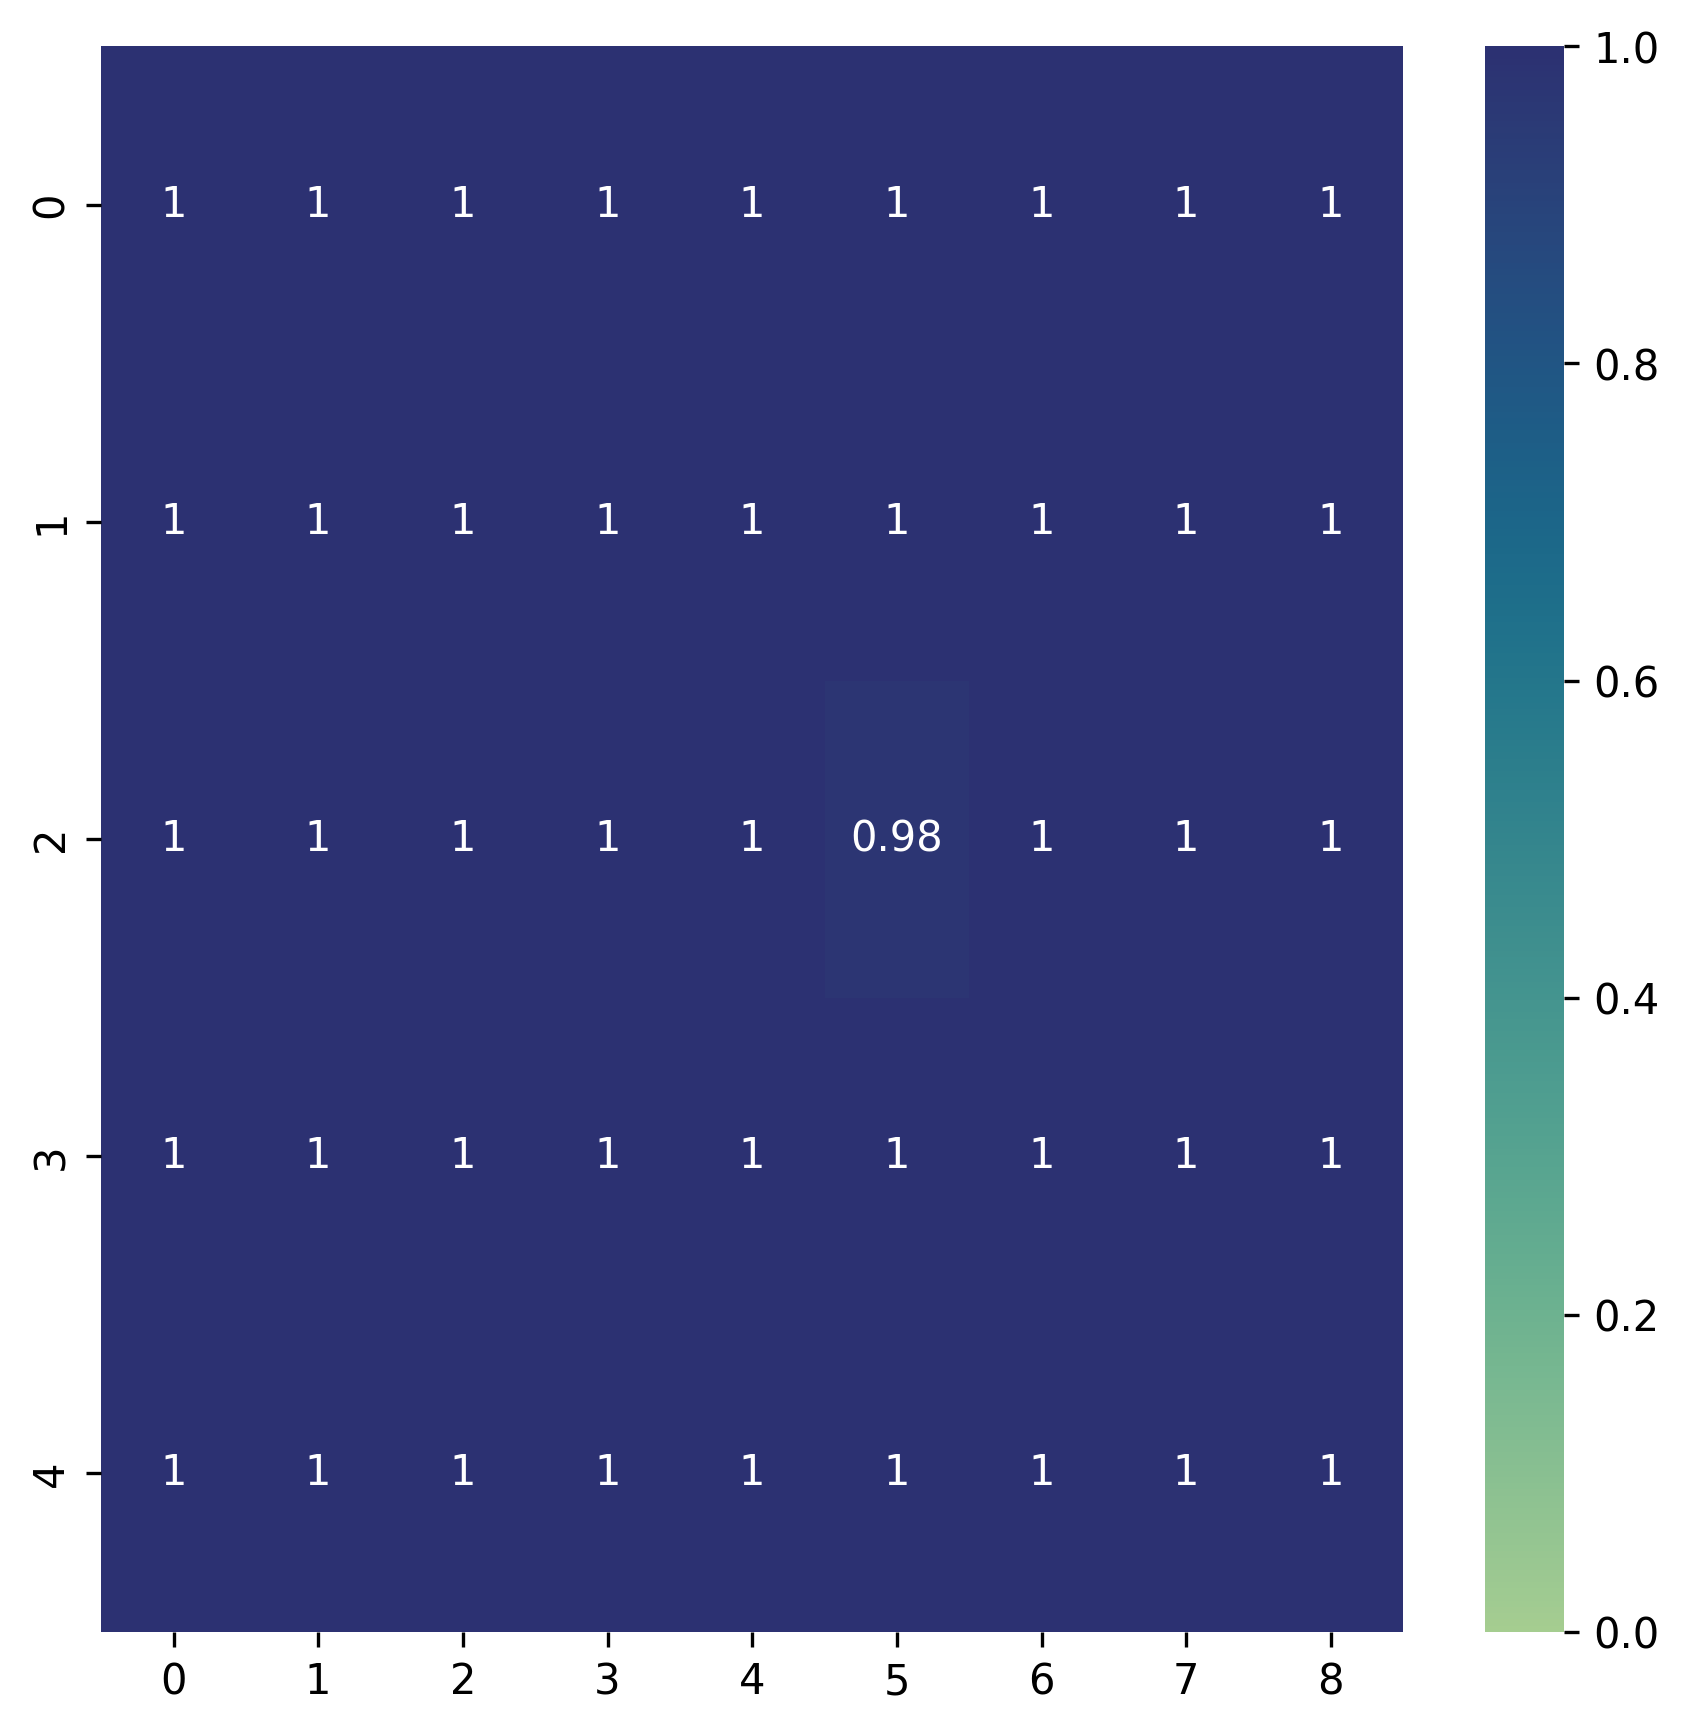

In [127]:
import seaborn as sns
from matplotlib import pyplot as plt

y_score_matrix = inference['y_score_matrix']
ax = sns.heatmap(y_score_matrix, annot=True, vmin=0, vmax=1, cmap="crest")

plt.show()

In [128]:
# get top sentence pairs for better interpretation
inference_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, above_threshold=0.8)

html = '<table>'
html += f'<caption><strong>{len(inference_pairs)} entailment(s) found</strong></caption>'
html += '<thead><tr><th>Sentence</th> <th>Score</th> </tr></thead>'
html += '<tbody>'

for pairs in inference_pairs:
    
    html += '<tr>'
    #tokens = pairs['pair_token']
    #attention = pairs['pair_attention']
    #html += '<td>'+ highlight(tokens, attention) +'</td>'
    source_words = block_words['source'][pairs['idx_sent_source']]
    target_words = block_words['target'][pairs['idx_sent_target']]
    
    source_words = highlight(source_words, pairs['attention_source'])
    target_words = highlight(target_words, pairs['attention_target'])
    
    html += '<td>'+ source_words + ' '+ '<u>' + target_words + '</u>' +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))

In [129]:
# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.9, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.9)

def article_identity(df_article, article_id):
    """Reformat identity for article"""
    authors = df_article.loc[article_id,'authors']
    if len(authors) == 1:
        authors = authors[0]
    else:
        ', '.join(authors)
    year = df_article.loc[article_id,'publicationYear'].astype(str)
    title = df_article.loc[article_id,'title']
    return authors + '. ' + year + '. "' +  title + '"'

html = '<table>'
html += f'<caption><strong>Explanation between the 2 textblocks</strong></caption>'

source_article_id = link['source.article.id']
target_article_id = link['target.article.id']
source_identity = article_identity(df_article, source_article_id)
target_identity = article_identity(df_article, target_article_id)

html += '<thead><tr><th>Source : '+source_identity+'</th> <th>Target : '+target_identity+'</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'


# Prepare the tokens
flat_block_words = {
    side : [token for sentence in block_words[side] for token in sentence] for side in block_words
}

flat_block_attention = { 
    side: [att for sentence in block_attentions[side] for att in sentence] for side in block_words
}

# First line : block text + score + type
html += '<tr>'

html += '<td>'+ highlight(flat_block_words['source'], flat_block_attention['source'])+ '</td>'
html += '<td>'+ highlight(flat_block_words['target'], flat_block_attention['target'])+ '</td>'

# score
html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'

# type
html += '<td>'+ ranking_output['type'] +'</td>'
html += '</tr>'

html += '</tbody>'
html += '</table>'
display(HTML(html))



# Evaluation in pre-established links

## QA Links

## Similarity Links

## TF-IDF